In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install pytorch_lightning
    !pip install neuralforecast

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import torch
from torch.utils.data import DataLoader

import pytorch_lightning as pl

import neuralforecast as nf
from neuralforecast.data.datasets.epf import EPF
from pytorch_lightning.callbacks import EarlyStopping
from neuralforecast.data.tsloader import TimeSeriesLoader
from neuralforecast.experiments.utils import create_datasets
from neuralforecast.data.tsdataset import IterateWindowsDataset

In [3]:
warnings.filterwarnings("ignore") # Comment out 

In [4]:
VAL_PERC = .1
TEST_PERC = .1
first_n=1000 #Grab the first n time-series
N_TIME_SERIES = first_n

In [5]:
mc_model = {}

mc_model['seq_len'] = 96 # Input sequence size.
mc_model['label_len'] = 96 // 2 # Label sequence size. (Input buffer length for decoder)
mc_model['pred_len'] = 28 # Prediction sequence size.
mc_model['output_attention'] = False # If true use output attention for Transformer model.
mc_model['enc_in'] = N_TIME_SERIES #  Number of encoders in data embedding layers.
mc_model['dec_in'] = N_TIME_SERIES #  Number of decoders in data embedding layers.
mc_model['d_model'] = 512 #  Number of nodes for embedding layers.
mc_model['c_out'] = N_TIME_SERIES # Number of output nodes in projection layer.
mc_model['embed'] = 'timeF' #  Type of embedding layers.
mc_model['freq'] = 'h' # Frequency for embedding layers.
mc_model['dropout'] = 0.05 # Float between (0, 1). Dropout for Transformer.
mc_model['factor'] = 1 # Factor for attention layer.
mc_model['n_heads'] = 8 #  Number of heads in attention layer.
mc_model['d_ff'] = 2_048 #  Number of inputs in encoder layers.
mc_model['moving_avg'] = 25  #  Moving average for encoder and decoder layers.
mc_model['activation'] = 'gelu' #  Activation function for encoder layer.
mc_model['e_layers'] = 2 # Number of encoder layers.
mc_model['d_layers'] = 1 # Number of decoder layers.
mc_model['loss_train'] = 'MAE' # Loss to optimize. An item from ['MAPE', 'MASE', 'SMAPE', 'MSE', 'MAE', 'QUANTILE', 'QUANTILE2']. 
mc_model['loss_hypar'] = 0.5 # Hyperparameter for chosen loss.
mc_model['loss_valid'] = 'MAE'# Validation loss.An item from ['MAPE', 'MASE', 'SMAPE', 'RMSE', 'MAE', 'QUANTILE'].
mc_model['learning_rate'] = 0.001 # Learning rate between (0, 1).
mc_model['lr_decay'] = 0.5 # Decreasing multiplier for the learning rate.
mc_model['weight_decay'] = 0. # L2 penalty for optimizer.
mc_model['lr_decay_step_size'] = 2 # Steps between each learning rate decay.
mc_model['random_seed'] = 1 # random_seed for pseudo random pytorch initializer and numpy random generator.

# Dataset parameters
mc_data = {}
mc_data['mode'] = 'iterate_windows'
mc_data['n_time_in'] = mc_model['seq_len'] # Input sequence length
mc_data['n_time_out'] = mc_model['pred_len'] # Prediction sequence length
mc_data['batch_size'] = 1 # Batch size 
mc_data['normalizer_y'] = None 
mc_data['normalizer_x'] = None
mc_data['max_epochs'] = 1 # Maximum number of training epochs
mc_data['max_steps'] = None # maximum number of training steps
mc_data['early_stop_patience'] = 20 #Number of consecutive violations of early stopping criteria to end training


In [6]:
df=pd.read_pickle("m5_aggregate_df.pkl").reset_index(drop=True)
df=df.loc[df['id'].isin(df['id'].unique()[0:first_n])]
df.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean
0,14370,1437,3,1,0,0,36,0,2011-03-05,11106,...,0.561035,0.695801,0.695801,0.321533,0.216553,0.216553,1.304688,0.801758,1.020508,1.142578
1,14380,1438,3,1,0,0,36,0,2011-03-05,11106,...,0.561035,0.695801,0.695801,0.253906,0.259766,0.259766,1.304688,0.801758,1.020508,1.142578
2,14390,1439,3,1,0,0,36,0,2011-03-05,11106,...,0.561035,0.695801,0.695801,0.156982,0.076660,0.076660,1.304688,0.801758,1.020508,0.428467
3,14400,1440,3,1,0,0,36,0,2011-03-05,11106,...,0.561035,0.695801,0.695801,1.694336,2.011719,2.011719,1.304688,0.801758,1.020508,0.285645
4,14410,1441,3,1,0,0,36,0,2011-03-05,11106,...,0.561035,0.695801,0.695801,0.958984,0.755371,0.755371,1.304688,0.801758,1.020508,0.000000


In [7]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'sold_lag_1',
       'sold_lag_2', 'sold_lag_3', 'sold_lag_6', 'sold_lag_12', 'sold_lag_24',
       'sold_lag_36', 'iteam_sold_avg', 'state_sold_avg', 'store_sold_avg',
       'cat_sold_avg', 'dept_sold_avg', 'cat_dept_sold_avg',
       'store_item_sold_avg', 'cat_item_sold_avg', 'dept_item_sold_avg',
       'state_store_sold_avg', 'state_store_cat_sold_avg',
       'store_cat_dept_sold_avg', 'rolling_sold_mean'],
      dtype='object')

In [8]:
#Static variables
S_df = None

#Training Data
Y_df=df[['id','date','sold']]
Y_df.columns=['unique_id','ds','y']

#Exogenous Variable Training Data
X_df=df[['id','date','sold_lag_2', 'sold_lag_3', 'sold_lag_6', 'sold_lag_12']]
X_df.columns=['unique_id','ds','ex_1','ex_2','ex_3','ex_4']

f_cols = X_df.drop(columns=['unique_id', 'ds']).columns.to_list()

In [9]:
n_ds = Y_df["ds"].nunique()
n_val = int(VAL_PERC * n_ds)
n_test = int(TEST_PERC * n_ds)

train_dataset, val_dataset, test_dataset, scaler_y = create_datasets(mc=mc_data,
                                                                     S_df=None, 
                                                                     Y_df=Y_df, X_df=X_df,
                                                                     f_cols=f_cols,
                                                                     ds_in_val=n_val,
                                                                     ds_in_test=n_test)



INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2015-05-31 2016-06-19
1           2011-03-05 2015-05-30
INFO:root:
Total data 			1934000 time stamps 
Available percentage=100.0, 	1934000 time stamps 
Insample  percentage=80.04, 	1548000 time stamps 
Outsample percentage=19.96, 	386000 time stamps 

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2011-03-05 2016-06-19
1           2015-05-31 2015-12-09
INFO:root:
Total data 			1934000 time stamps 
Available percentage=100.0, 	1934000 time stamps 
Insample  percentage=9.98, 	193000 time stamps 
Outsample percentage=90.02, 	1741000 time stamps 

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2011-03-05 2015-12-0

In [10]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=int(mc_data['batch_size']),
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=int(mc_data['batch_size']),
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=int(mc_data['batch_size']),
                         shuffle=False)

In [11]:
model = nf.models.transformer.autoformer.Autoformer(**mc_model)


In [12]:
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta=1e-4, 
                                            patience=mc_data['early_stop_patience'],
                                            verbose=True,
                                            mode="min")

trainer = pl.Trainer(max_epochs=mc_data['max_epochs'], 
                     max_steps=mc_data['max_steps'],
                     gradient_clip_val=1.0,
                     progress_bar_refresh_rate=10, 
                     check_val_every_n_epoch=1,
                     log_every_n_steps=500, 
                     callbacks=[early_stopping])

trainer.fit(model, train_loader, val_loader)


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Set SLURM handle signals.

  | Name  | Type        | Params
--------------------------------------
0 | model | _Autoformer | 15.6 M
--------------------------------------
15.6 M    Trainable params
0         Non-trainable params
15.6 M    Total params
62.484    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.059


In [13]:
model.return_decomposition = False
outputs = trainer.predict(model, test_loader)

Predicting: 1425it [00:00, ?it/s]

In [14]:
input_list = []
for d in test_loader:
    Y = d["Y"].squeeze()
    inp = Y[:, :mc_model['seq_len']].squeeze()
    input_list.append(inp)

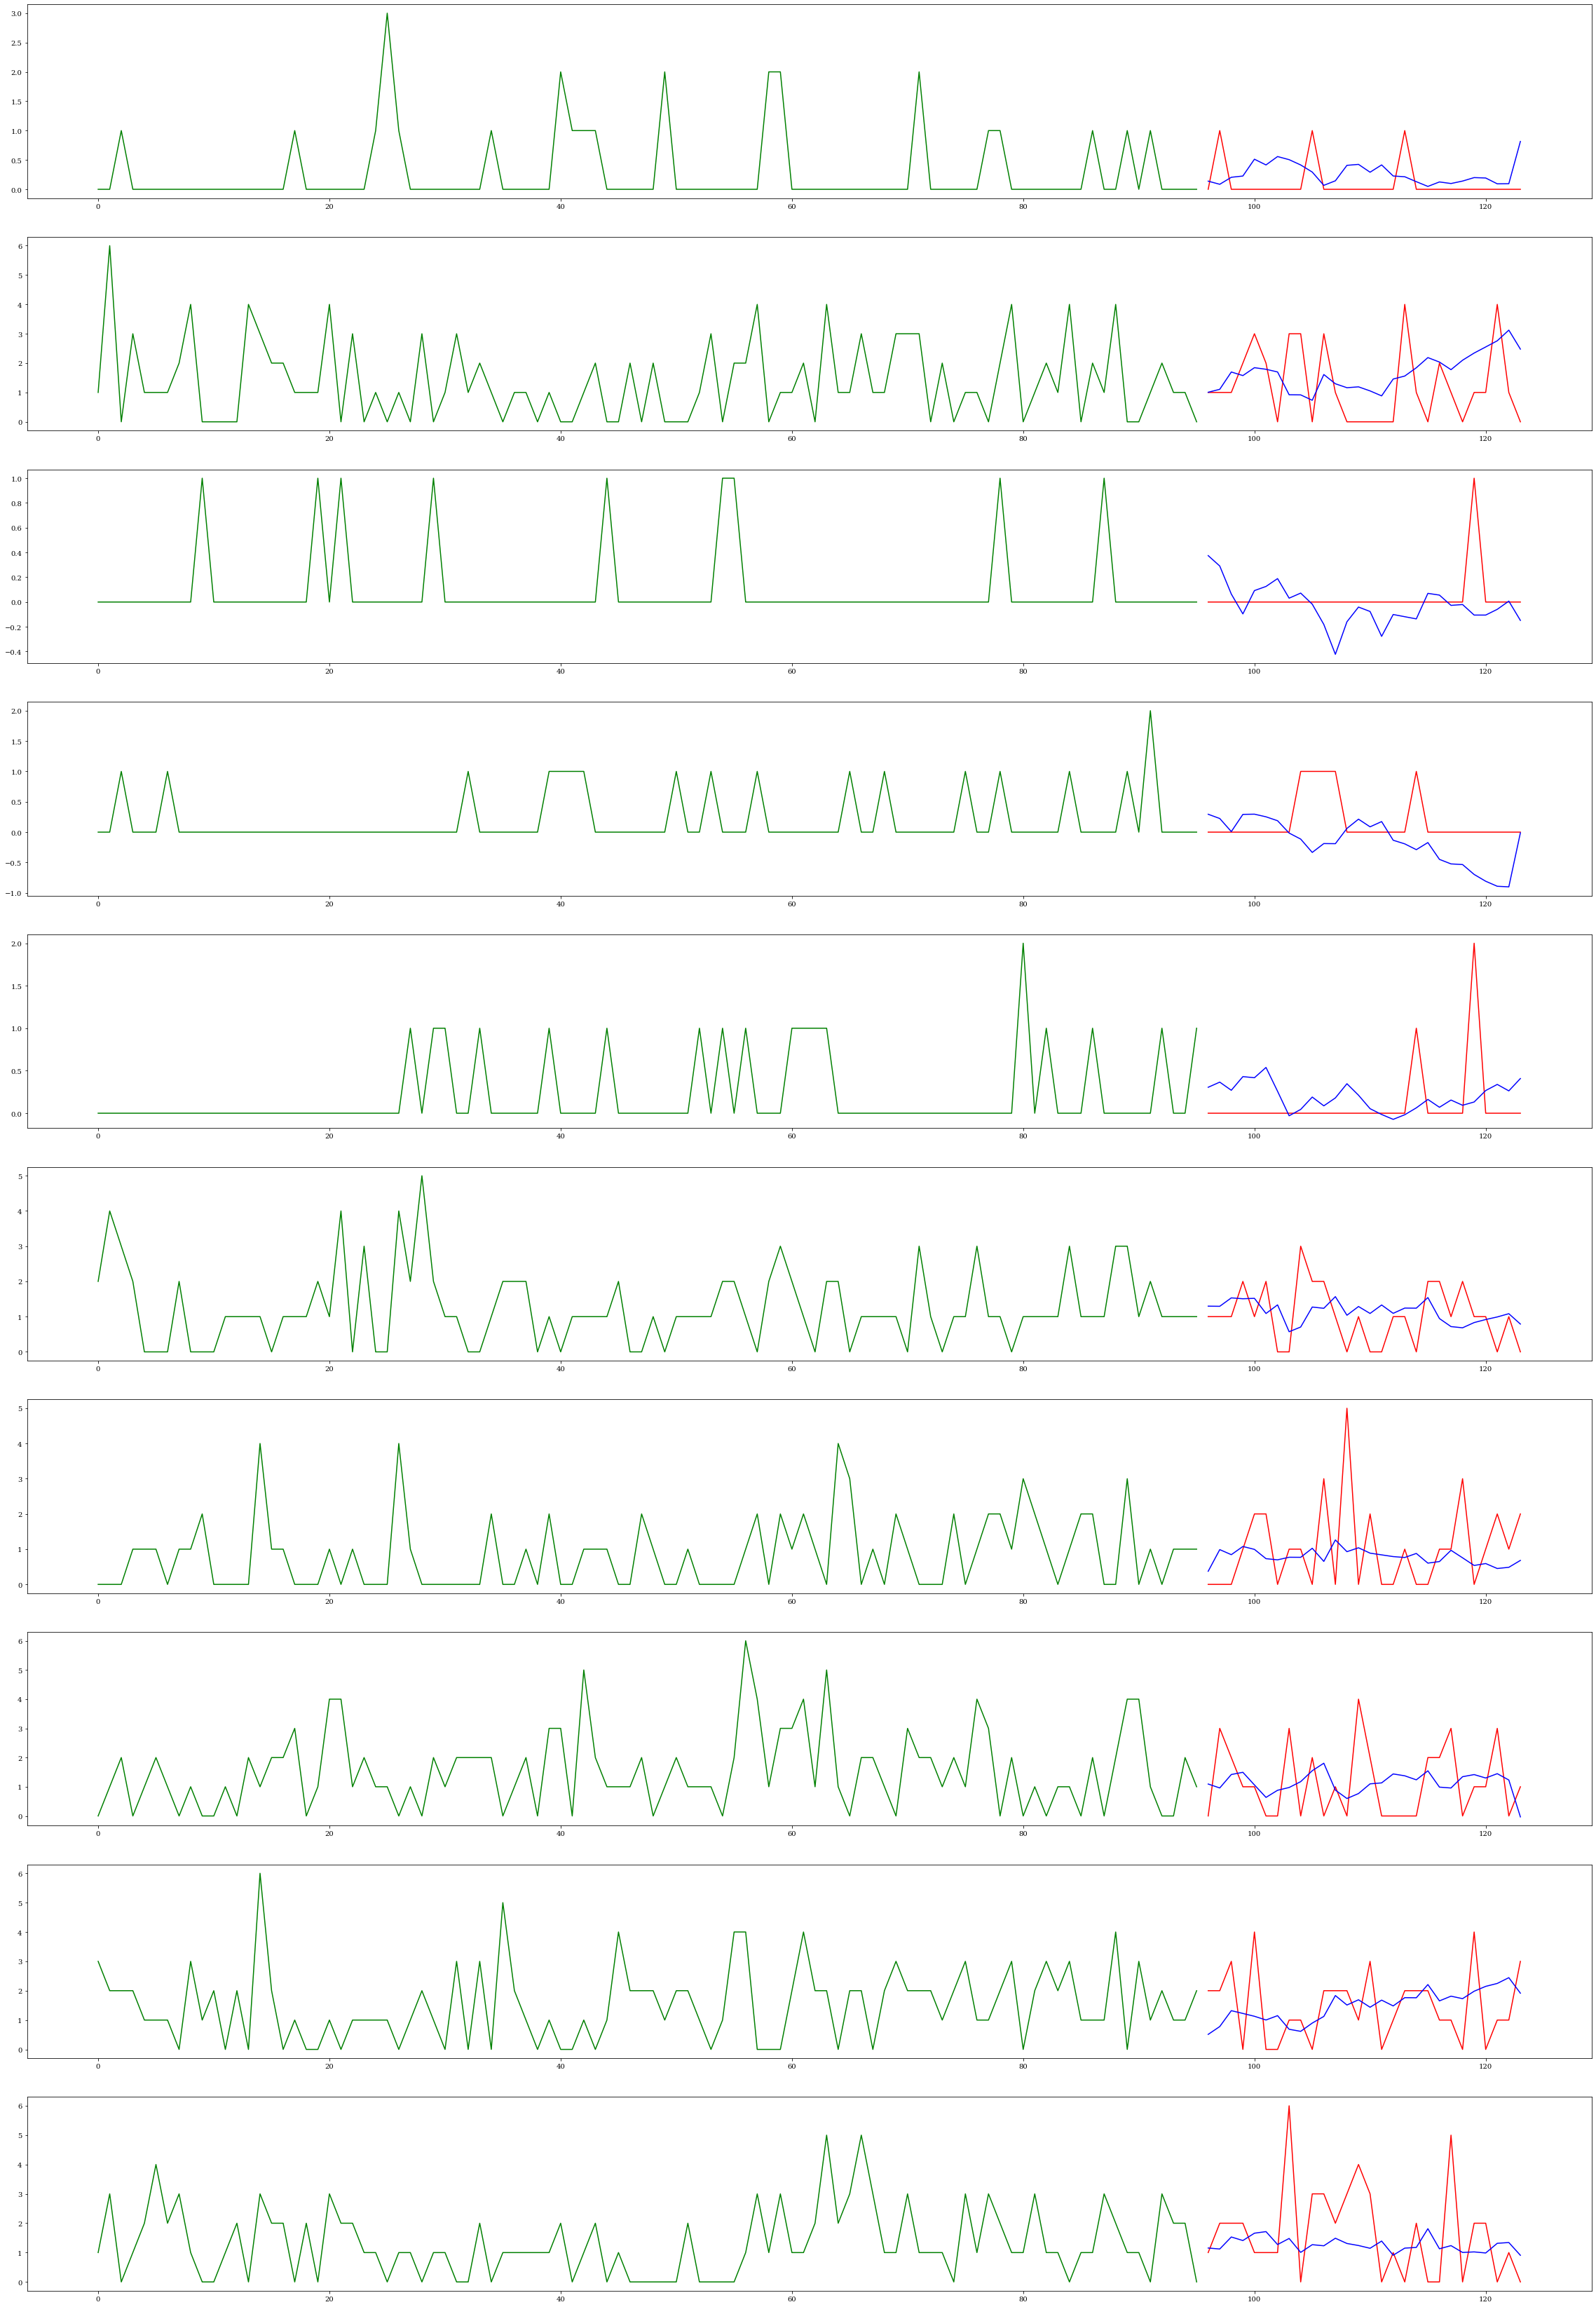

In [15]:
n_samples = 10
ss_indices = np.random.choice(N_TIME_SERIES, n_samples, replace=False).tolist()

f, axarr = plt.subplots(10, 1, figsize=(40, 60))
for i, ss_ind in enumerate(ss_indices):
    inp = input_list[0][ss_ind, :].cpu().numpy()

    out1 = outputs[0][0].squeeze()[:, ss_ind].cpu().numpy()
    out2 = outputs[0][1].squeeze()[:, ss_ind].cpu().numpy()

    inp_index = [j for j in range(mc_model['seq_len'])]
    out_index = [j for j in range(mc_model['seq_len'], mc_model['seq_len'] + mc_model['pred_len'])]

    axarr[i].plot(inp_index, inp, c="green")
    axarr[i].plot(out_index, out1, c="red")
    axarr[i].plot(out_index, out2, c="blue")

In [16]:
# Aggregate list of ground truth and prediction series in to lists
true_list = [output[0].squeeze().transpose(1, 0) for output in outputs]
pred_list = [output[1].squeeze().transpose(1, 0) for output in outputs]

# Stack lists into tensors along the sample/batch dimension
trues = torch.concat(true_list, dim=0)
preds = torch.concat(pred_list, dim=0)

# Calculate Losses
mse = mean_squared_error(trues.cpu().numpy(), preds.cpu().numpy())
mae = mean_absolute_error(trues.cpu().numpy(), preds.cpu().numpy())

print(f"MSE: {mse} MAE: {mae}")

MSE: 4.517886638641357 MAE: 1.056161642074585


In [18]:
# #Quick averaging

# mae_list=[]
# mse_list=[]

# for tpr in [0.05,0.1,0.15,0.2,0.25,0.3]:
#     n_ds = Y_df["ds"].nunique()
#     n_val = int(VAL_PERC * n_ds)
#     n_test = int(tpr * n_ds)

#     train_d, val_d, test_d, _ = create_datasets(mc=mc_data,S_df=None,Y_df=Y_df, X_df=X_df,
#                                                                          f_cols=f_cols,
#                                                                          ds_in_val=n_val,
#                                                                          ds_in_test=n_test)

#     train_l = DataLoader(dataset=train_d,
#                           batch_size=int(mc_data['batch_size']),
#                           shuffle=True,
#                           drop_last=True)

#     val_l = DataLoader(dataset=val_d,
#                             batch_size=int(mc_data['batch_size']),
#                             shuffle=False)

#     test_l = DataLoader(dataset=test_d,
#                          batch_size=int(mc_data['batch_size']),
#                          shuffle=False)
    
#     early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', 
#                                             min_delta=1e-4, 
#                                             patience=mc_data['early_stop_patience'],
#                                             verbose=True,
#                                             mode="min")

#     trainer = pl.Trainer(max_epochs=mc_data['max_epochs'], 
#                          max_steps=mc_data['max_steps'],
#                          gradient_clip_val=1.0,
#                          progress_bar_refresh_rate=10, 
#                          check_val_every_n_epoch=1,
#                          log_every_n_steps=500, 
#                          callbacks=[early_stopping])

#     trainer.fit(model, train_l, val_l)

#     outs = trainer.predict(model, test_l)
    
#     # Aggregate list of ground truth and prediction series in to lists
#     true_list = [output[0].squeeze().transpose(1, 0) for output in outs]
#     pred_list = [output[1].squeeze().transpose(1, 0) for output in outs]

#     # Stack lists into tensors along the sample/batch dimension
#     trues = torch.concat(true_list, dim=0)
#     preds = torch.concat(pred_list, dim=0)

#     # Calculate Losses
#     mse = mean_squared_error(trues.cpu().numpy(), preds.cpu().numpy())
#     mae = mean_absolute_error(trues.cpu().numpy(), preds.cpu().numpy())

#     print("Test size:",tpr,f"MSE: {mse} MAE: {mae}")
    
#     mae_list.append(mae)
#     mse_list.append(mse)
    
#Avg MSE is 4.5, average MAE is 1.05

In [63]:
# def forecast(self: nf.models.transformer.autoformer.Autoformer, Y_df: pd.DataFrame, mc_model: dict, f_cols: list, X_df: pd.DataFrame = None, S_df: pd.DataFrame = None, 
#             trainer: pl.Trainer =None) -> pd.DataFrame:
#     """
#     Method for forecasting self.n_time_out periods after last timestamp of Y_df.

#     Parameters
#     ----------
#     Y_df: pd.DataFrame
#         Dataframe with target time-series data, needs 'unique_id','ds' and 'y' columns.
#     X_df: pd.DataFrame
#         Dataframe with exogenous time-series data, needs 'unique_id' and 'ds' columns.
#         Note that 'unique_id' and 'ds' must match Y_df plus the forecasting horizon.
#     S_df: pd.DataFrame
#         Dataframe with static data, needs 'unique_id' column.
#     bath_size: int
#         Batch size for forecasting.
#     trainer: pl.Trainer
#         Trainer object for model training and evaluation.

#     Returns
#     ----------
#     forecast_df: pd.DataFrame
#         Dataframe with forecasts.
#     """

#     # Add forecast dates to Y_df
#     Y_df['ds'] = pd.to_datetime(Y_df['ds'])
#     if X_df is not None:
#         X_df['ds'] = pd.to_datetime(X_df['ds'])
#     self.frequency = pd.infer_freq(Y_df[Y_df['unique_id']==Y_df['unique_id'][0]]['ds']) # Infer with first unique_id series
#     self.pred_len=mc_model['pred_len']
#     self.seq_len=mc_model['seq_len']
#     self.suffixes=["_left","_right"]
#     forecast_dates = pd.date_range(Y_df['ds'].max(), periods=self.pred_len+1, freq=self.frequency)[1:]
#     index = pd.MultiIndex.from_product([Y_df['unique_id'].unique(), forecast_dates], names=['unique_id', 'ds'])
#     forecast_df = pd.DataFrame({'y':[0]}, index=index).reset_index()
#     forecast_ex_df = pd.DataFrame({'ex_1':[0],'ex_2':[0],'ex_3':[0],'ex_4':[0]}, index=index).reset_index()

#     Y_df = Y_df.append(forecast_df).sort_values(['unique_id','ds']).reset_index(drop=True)
#     X_df = X_df.append(forecast_ex_df).sort_values(['unique_id','ds']).reset_index(drop=True)

#     # Dataset, loader and trainer
#     dataset = IterateWindowsDataset(S_df=S_df, Y_df=Y_df, X_df=X_df,
#                                     mask_df=None, f_cols=f_cols,
#                                     input_size=self.seq_len,
#                                     output_size=self.pred_len,
#                                     ds_in_test=self.pred_len,
#                                     is_test=True,
#                                     verbose=True)

#     loader = TimeSeriesLoader(dataset=dataset,
#                                 batch_size=1000,
#                                 shuffle=False)

#     if trainer is None:
#         gpus = -1 if torch.cuda.is_available() else 0
#         trainer = pl.Trainer(progress_bar_refresh_rate=1,
#                              gpus=gpus,
#                              logger=False)

#     # Forecast
#     outputs = trainer.predict(self, loader)

#     # Process forecast and include in forecast_df
#     _, forecast, _ = [torch.cat(output).cpu().numpy() for output in zip(*outputs)]
#     forecast = np.transpose(forecast, (0, 2, 1))
#     forecast_df['y'] = forecast.flatten()

#     return forecast_df

# nf.models.transformer.autoformer.Autoformer.forecast = forecast.__get__(nf.models.transformer.autoformer.Autoformer)


In [64]:
# model.forecast(Y_df=Y_df, X_df=X_df, S_df=S_df, trainer=trainer, mc_model=mc_model, f_cols=f_cols)
